## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp004'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 8 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

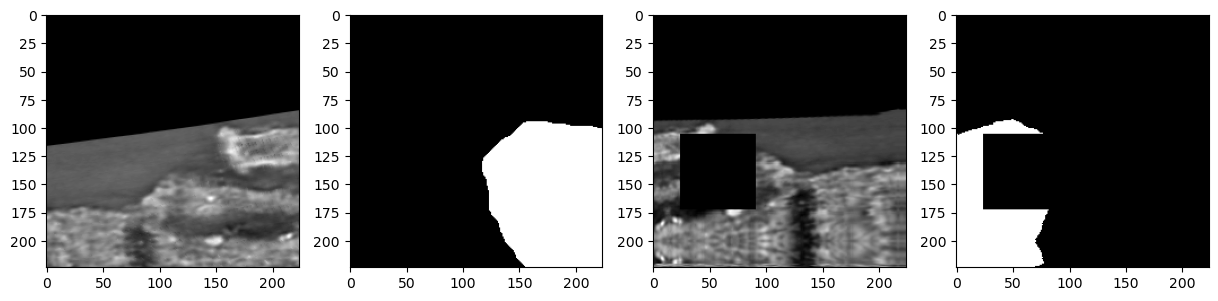

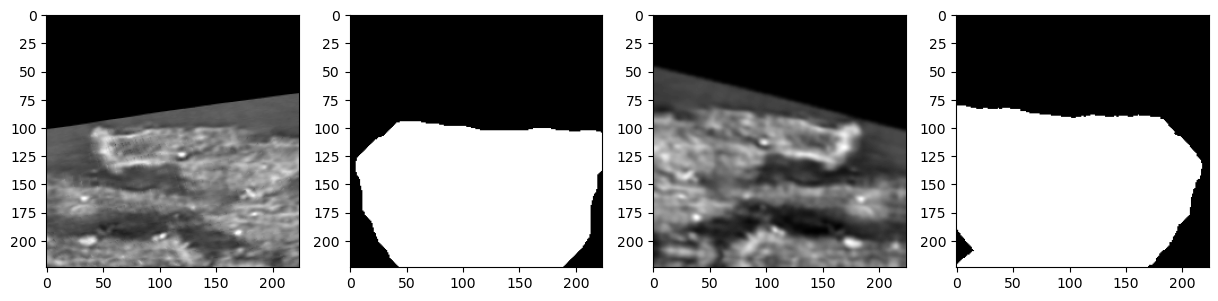

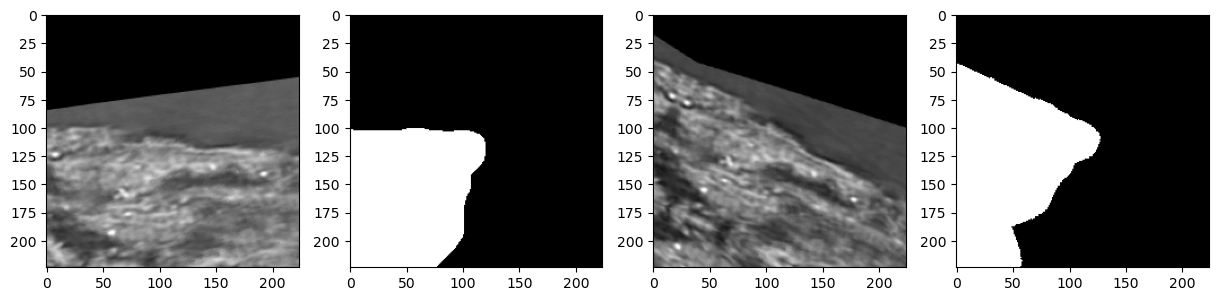

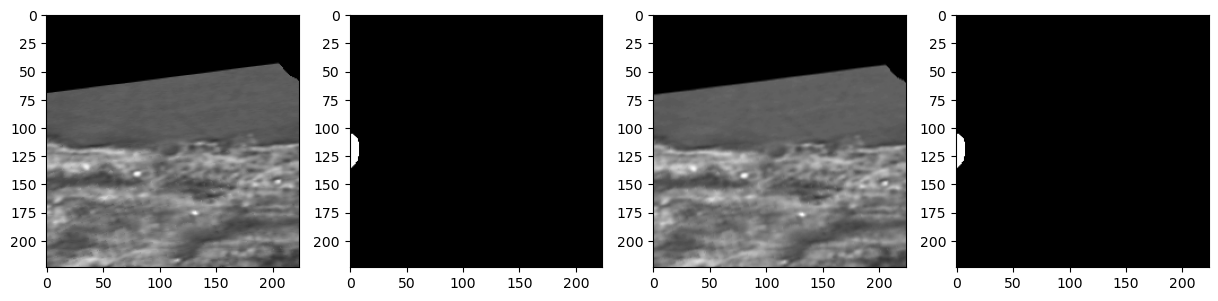

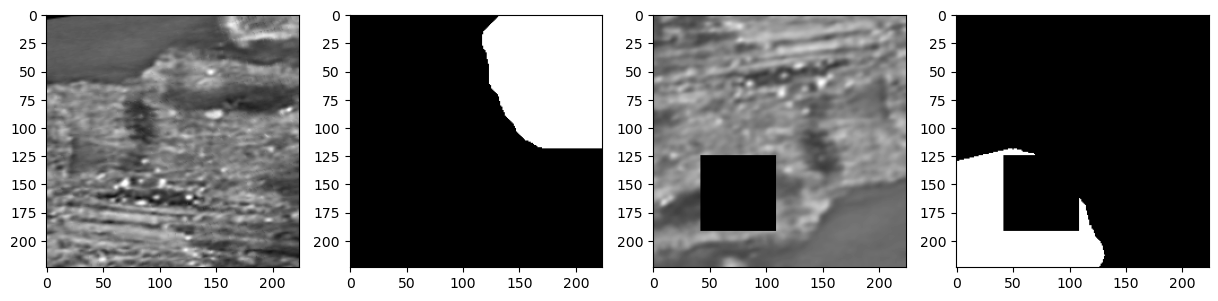

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14209319887549468
th: 0.15, fbeta: 0.1420882212058084
th: 0.2, fbeta: 0.14285044911085584
th: 0.25, fbeta: 0.20612026788489618
th: 0.3, fbeta: 0.24637016332772518
th: 0.35, fbeta: 0.27762306123006697
th: 0.4, fbeta: 0.29107854292053853
th: 0.45, fbeta: 0.26260075320218257


best_th: 0.4, fbeta: 0.29107854292053853
Epoch 1 - avg_train_loss: 0.5625  avg_val_loss: 0.4229  time: 142s
Epoch 1 - avgScore: 0.2911
Epoch 1 - Save Best Score: 0.2911 Model
Epoch 1 - Save Best Loss: 0.4229 Model


th: 0.5, fbeta: 0.19565715995507849


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420968247818967
th: 0.15, fbeta: 0.19434054375611515
th: 0.2, fbeta: 0.253669508248222
th: 0.25, fbeta: 0.3013992246842686
th: 0.3, fbeta: 0.252678717432093
th: 0.35, fbeta: 0.18279088993571121
th: 0.4, fbeta: 0.12018970441036135
th: 0.45, fbeta: 0.07329658477159727


best_th: 0.25, fbeta: 0.3013992246842686
Epoch 2 - avg_train_loss: 0.3621  avg_val_loss: 0.3602  time: 145s
Epoch 2 - avgScore: 0.3014
Epoch 2 - Save Best Score: 0.3014 Model
Epoch 2 - Save Best Loss: 0.3602 Model


th: 0.5, fbeta: 0.03767599313474965


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.3336194208428932
th: 0.15, fbeta: 0.24660872477511409
th: 0.2, fbeta: 0.14421705475847219
th: 0.25, fbeta: 0.07874615501535318
th: 0.3, fbeta: 0.04216359947621012
th: 0.35, fbeta: 0.024251885242282754
th: 0.4, fbeta: 0.012720386745542066
th: 0.45, fbeta: 0.005486894894260014


best_th: 0.1, fbeta: 0.3336194208428932
Epoch 3 - avg_train_loss: 0.2476  avg_val_loss: 0.3578  time: 146s
Epoch 3 - avgScore: 0.3336
Epoch 3 - Save Best Score: 0.3336 Model
Epoch 3 - Save Best Loss: 0.3578 Model


th: 0.5, fbeta: 0.0023703122506114325


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.387490617724661
th: 0.15, fbeta: 0.32319704287639306
th: 0.2, fbeta: 0.26507071904478324
th: 0.25, fbeta: 0.2183028710310052
th: 0.3, fbeta: 0.1758732721691461
th: 0.35, fbeta: 0.14034120142346296
th: 0.4, fbeta: 0.11094443875279843
th: 0.45, fbeta: 0.0846653963261204


best_th: 0.1, fbeta: 0.387490617724661
Epoch 4 - avg_train_loss: 0.2109  avg_val_loss: 0.3885  time: 147s
Epoch 4 - avgScore: 0.3875
Epoch 4 - Save Best Score: 0.3875 Model
Epoch 4 - Save Best Loss: 0.3885 Model


th: 0.5, fbeta: 0.06175195793658805


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3525656124140381
th: 0.15, fbeta: 0.38498504195392386
th: 0.2, fbeta: 0.39699241427872023
th: 0.25, fbeta: 0.3886537752974207
th: 0.3, fbeta: 0.37169129762869446
th: 0.35, fbeta: 0.3490599961836163
th: 0.4, fbeta: 0.32465747812482354
th: 0.45, fbeta: 0.29160330931492884


best_th: 0.2, fbeta: 0.39699241427872023
Epoch 5 - avg_train_loss: 0.1952  avg_val_loss: 0.3421  time: 146s
Epoch 5 - avgScore: 0.3970
Epoch 5 - Save Best Score: 0.3970 Model
Epoch 5 - Save Best Loss: 0.3421 Model


th: 0.5, fbeta: 0.25380798592044396


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31152375939287563
th: 0.15, fbeta: 0.23746767832825436
th: 0.2, fbeta: 0.159559518402312
th: 0.25, fbeta: 0.10295323666731572
th: 0.3, fbeta: 0.06499074847243838
th: 0.35, fbeta: 0.04077277063937776
th: 0.4, fbeta: 0.025028702495722352
th: 0.45, fbeta: 0.015332892931703153


best_th: 0.1, fbeta: 0.31152375939287563
Epoch 6 - avg_train_loss: 0.1886  avg_val_loss: 0.4348  time: 145s
Epoch 6 - avgScore: 0.3115


th: 0.5, fbeta: 0.010170113531502078


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33914982786262543
th: 0.15, fbeta: 0.2632136308751644
th: 0.2, fbeta: 0.20246836475567073
th: 0.25, fbeta: 0.1492414731292445
th: 0.3, fbeta: 0.10478990164169273
th: 0.35, fbeta: 0.07090447054999942
th: 0.4, fbeta: 0.04719996491995013
th: 0.45, fbeta: 0.028563998310702894


best_th: 0.1, fbeta: 0.33914982786262543
Epoch 7 - avg_train_loss: 0.1772  avg_val_loss: 0.4501  time: 145s
Epoch 7 - avgScore: 0.3391


th: 0.5, fbeta: 0.01461358379998226


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2655750703222998
th: 0.15, fbeta: 0.2030969329029644
th: 0.2, fbeta: 0.16191022171151756
th: 0.25, fbeta: 0.13000597024234084
th: 0.3, fbeta: 0.10266904345595719
th: 0.35, fbeta: 0.0782072347122053
th: 0.4, fbeta: 0.05901802828984156
th: 0.45, fbeta: 0.044943205578679014


best_th: 0.1, fbeta: 0.2655750703222998
Epoch 8 - avg_train_loss: 0.1728  avg_val_loss: 0.5368  time: 146s
Epoch 8 - avgScore: 0.2656


th: 0.5, fbeta: 0.0353132252085602


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3255242694976279
th: 0.15, fbeta: 0.28458318041621694
th: 0.2, fbeta: 0.24001672166132854
th: 0.25, fbeta: 0.20911737262546476
th: 0.3, fbeta: 0.17246320313949193
th: 0.35, fbeta: 0.14054991131383027
th: 0.4, fbeta: 0.11171088898672908
th: 0.45, fbeta: 0.08612797786882562


best_th: 0.1, fbeta: 0.3255242694976279
Epoch 9 - avg_train_loss: 0.1638  avg_val_loss: 0.5332  time: 146s
Epoch 9 - avgScore: 0.3255


th: 0.5, fbeta: 0.06366264557165999


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32220880198490487
th: 0.15, fbeta: 0.26332486624504287
th: 0.2, fbeta: 0.20297603140051526
th: 0.25, fbeta: 0.15355654629023727
th: 0.3, fbeta: 0.11229547430003346
th: 0.35, fbeta: 0.07939396606085292
th: 0.4, fbeta: 0.05670493284394552
th: 0.45, fbeta: 0.03993739994644277


best_th: 0.1, fbeta: 0.32220880198490487
Epoch 10 - avg_train_loss: 0.1566  avg_val_loss: 0.4720  time: 146s
Epoch 10 - avgScore: 0.3222


th: 0.5, fbeta: 0.02721771690119107


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30754072952872746
th: 0.15, fbeta: 0.2729802275969258
th: 0.2, fbeta: 0.2372613928924015
th: 0.25, fbeta: 0.20870118920441164
th: 0.3, fbeta: 0.1814745839318765
th: 0.35, fbeta: 0.15211987170805288
th: 0.4, fbeta: 0.12475935669411362
th: 0.45, fbeta: 0.1024359877556579


best_th: 0.1, fbeta: 0.30754072952872746
Epoch 11 - avg_train_loss: 0.1467  avg_val_loss: 0.5395  time: 144s
Epoch 11 - avgScore: 0.3075


th: 0.5, fbeta: 0.08261564196010443


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3512921350662281
th: 0.15, fbeta: 0.3260515749811082
th: 0.2, fbeta: 0.29740741357553885
th: 0.25, fbeta: 0.26605143340430926
th: 0.3, fbeta: 0.233528883161564
th: 0.35, fbeta: 0.20082732812055878
th: 0.4, fbeta: 0.1686805087995107
th: 0.45, fbeta: 0.1406539829116214


best_th: 0.1, fbeta: 0.3512921350662281
Epoch 12 - avg_train_loss: 0.1458  avg_val_loss: 0.5618  time: 147s
Epoch 12 - avgScore: 0.3513


th: 0.5, fbeta: 0.11594003553038768


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38005905227678144
th: 0.15, fbeta: 0.38984534175779634
th: 0.2, fbeta: 0.39085625740404306
th: 0.25, fbeta: 0.3854650851393149
th: 0.3, fbeta: 0.3784174734866599
th: 0.35, fbeta: 0.37004356603168076
th: 0.4, fbeta: 0.35795738463220383
th: 0.45, fbeta: 0.33985576263916084


best_th: 0.2, fbeta: 0.39085625740404306
Epoch 13 - avg_train_loss: 0.1344  avg_val_loss: 0.4690  time: 146s
Epoch 13 - avgScore: 0.3909


th: 0.5, fbeta: 0.3193203310435511


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3530735245356494
th: 0.15, fbeta: 0.3235024870776151
th: 0.2, fbeta: 0.2875412310775623
th: 0.25, fbeta: 0.25031240429338986
th: 0.3, fbeta: 0.21537063549406998
th: 0.35, fbeta: 0.18386397079112624
th: 0.4, fbeta: 0.15528951696287485
th: 0.45, fbeta: 0.12869947613536378


best_th: 0.1, fbeta: 0.3530735245356494
Epoch 14 - avg_train_loss: 0.1293  avg_val_loss: 0.5809  time: 146s
Epoch 14 - avgScore: 0.3531


th: 0.5, fbeta: 0.10347434668423838


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3438391712501291
th: 0.15, fbeta: 0.321769130322071
th: 0.2, fbeta: 0.296524536700499
th: 0.25, fbeta: 0.2697339760160749
th: 0.3, fbeta: 0.24045940965370527
th: 0.35, fbeta: 0.21143612178405058
th: 0.4, fbeta: 0.18373168067712098
th: 0.45, fbeta: 0.1588985099595472


best_th: 0.1, fbeta: 0.3438391712501291
Epoch 15 - avg_train_loss: 0.1225  avg_val_loss: 0.6957  time: 148s
Epoch 15 - avgScore: 0.3438


th: 0.5, fbeta: 0.1364670167472684


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3362854744109825
th: 0.15, fbeta: 0.3411557017202669
th: 0.2, fbeta: 0.3445394377567281
th: 0.25, fbeta: 0.34546794503719447
th: 0.3, fbeta: 0.34560176924026675
th: 0.35, fbeta: 0.3444406876644071
th: 0.4, fbeta: 0.34333290822404877
th: 0.45, fbeta: 0.34091290145066944


best_th: 0.3, fbeta: 0.34560176924026675
Epoch 16 - avg_train_loss: 0.1198  avg_val_loss: 0.6499  time: 145s
Epoch 16 - avgScore: 0.3456


th: 0.5, fbeta: 0.3372060427088518


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38899192727209114
th: 0.15, fbeta: 0.38762529716238103
th: 0.2, fbeta: 0.3779579101003147
th: 0.25, fbeta: 0.3603777998935816
th: 0.3, fbeta: 0.3432887469463008
th: 0.35, fbeta: 0.324793060995673
th: 0.4, fbeta: 0.3031173665236393
th: 0.45, fbeta: 0.2800791073408716


best_th: 0.1, fbeta: 0.38899192727209114
Epoch 17 - avg_train_loss: 0.1095  avg_val_loss: 0.5847  time: 145s
Epoch 17 - avgScore: 0.3890


th: 0.5, fbeta: 0.2561493868816765


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3557876239992494
th: 0.15, fbeta: 0.3390071253682381
th: 0.2, fbeta: 0.31553777115505627
th: 0.25, fbeta: 0.28960779184814145
th: 0.3, fbeta: 0.2665496252210845
th: 0.35, fbeta: 0.2436154554594494
th: 0.4, fbeta: 0.22065605522611673
th: 0.45, fbeta: 0.19555971183891174


best_th: 0.1, fbeta: 0.3557876239992494
Epoch 18 - avg_train_loss: 0.1067  avg_val_loss: 0.7013  time: 145s
Epoch 18 - avgScore: 0.3558


th: 0.5, fbeta: 0.1693239022934572


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.315360339669973
th: 0.15, fbeta: 0.29774256346732214
th: 0.2, fbeta: 0.27771831086914617
th: 0.25, fbeta: 0.2573201551221339
th: 0.3, fbeta: 0.2391988497186583
th: 0.35, fbeta: 0.22049124180849716
th: 0.4, fbeta: 0.2026426872011291
th: 0.45, fbeta: 0.18553676136124234


best_th: 0.1, fbeta: 0.315360339669973
Epoch 19 - avg_train_loss: 0.1011  avg_val_loss: 0.7230  time: 146s
Epoch 19 - avgScore: 0.3154


th: 0.5, fbeta: 0.16701966901640852


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36240592120556536
th: 0.15, fbeta: 0.3565547911896174
th: 0.2, fbeta: 0.34540936233654373
th: 0.25, fbeta: 0.33169340287027327
th: 0.3, fbeta: 0.3144902574561895
th: 0.35, fbeta: 0.29622643895960377
th: 0.4, fbeta: 0.2763140777093142
th: 0.45, fbeta: 0.2558372786476957


best_th: 0.1, fbeta: 0.36240592120556536
Epoch 20 - avg_train_loss: 0.0920  avg_val_loss: 0.6845  time: 145s
Epoch 20 - avgScore: 0.3624


th: 0.5, fbeta: 0.2352795717505493


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34959286607275036
th: 0.15, fbeta: 0.3406498203936058
th: 0.2, fbeta: 0.3292886064301287
th: 0.25, fbeta: 0.3152157403788458
th: 0.3, fbeta: 0.2984647687466658
th: 0.35, fbeta: 0.2802537324371201
th: 0.4, fbeta: 0.2602985781852773
th: 0.45, fbeta: 0.2376952057527251


best_th: 0.1, fbeta: 0.34959286607275036
Epoch 21 - avg_train_loss: 0.0898  avg_val_loss: 0.7535  time: 145s
Epoch 21 - avgScore: 0.3496


th: 0.5, fbeta: 0.21509240298203483


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33999881665125614
th: 0.15, fbeta: 0.3175517855631258
th: 0.2, fbeta: 0.2949608778284298
th: 0.25, fbeta: 0.26902212853492197
th: 0.3, fbeta: 0.24218300357665257
th: 0.35, fbeta: 0.2172921609666076
th: 0.4, fbeta: 0.1941594239174948
th: 0.45, fbeta: 0.17167315057608873


best_th: 0.1, fbeta: 0.33999881665125614
Epoch 22 - avg_train_loss: 0.0862  avg_val_loss: 0.7978  time: 145s
Epoch 22 - avgScore: 0.3400


th: 0.5, fbeta: 0.14940361980857533


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3199812807028016
th: 0.15, fbeta: 0.29863785593714715
th: 0.2, fbeta: 0.27492321741168224
th: 0.25, fbeta: 0.24964114400919524
th: 0.3, fbeta: 0.22270110080402405
th: 0.35, fbeta: 0.19530042838158151
th: 0.4, fbeta: 0.16807321373898843
th: 0.45, fbeta: 0.14462519742000443


best_th: 0.1, fbeta: 0.3199812807028016
Epoch 23 - avg_train_loss: 0.0826  avg_val_loss: 0.8302  time: 144s
Epoch 23 - avgScore: 0.3200


th: 0.5, fbeta: 0.12352398889717786


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31216377348855445
th: 0.15, fbeta: 0.2912987731863147
th: 0.2, fbeta: 0.26726086072916155
th: 0.25, fbeta: 0.24334497926390503
th: 0.3, fbeta: 0.21738231312699832
th: 0.35, fbeta: 0.19065461289429006
th: 0.4, fbeta: 0.1672751648475478
th: 0.45, fbeta: 0.14500397406749616


best_th: 0.1, fbeta: 0.31216377348855445
Epoch 24 - avg_train_loss: 0.0779  avg_val_loss: 0.8189  time: 145s
Epoch 24 - avgScore: 0.3122


th: 0.5, fbeta: 0.12374219274966429


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36941777193685144
th: 0.15, fbeta: 0.36113098419662876
th: 0.2, fbeta: 0.34638527856324725
th: 0.25, fbeta: 0.33037221205012196
th: 0.3, fbeta: 0.3112841502629757
th: 0.35, fbeta: 0.2898597863924326
th: 0.4, fbeta: 0.26813642008785454
th: 0.45, fbeta: 0.24403210841286188


best_th: 0.1, fbeta: 0.36941777193685144
Epoch 25 - avg_train_loss: 0.0757  avg_val_loss: 0.8275  time: 146s
Epoch 25 - avgScore: 0.3694


th: 0.5, fbeta: 0.2176755098704727


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3395494484164658
th: 0.15, fbeta: 0.3299561959852158
th: 0.2, fbeta: 0.31581551804764
th: 0.25, fbeta: 0.2961230680954049
th: 0.3, fbeta: 0.27345968329429876
th: 0.35, fbeta: 0.24974229688738256
th: 0.4, fbeta: 0.22806517275618468
th: 0.45, fbeta: 0.20465348090065622


best_th: 0.1, fbeta: 0.3395494484164658
Epoch 26 - avg_train_loss: 0.0763  avg_val_loss: 0.8942  time: 144s
Epoch 26 - avgScore: 0.3395


th: 0.5, fbeta: 0.17968364972918904


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3495219997095385
th: 0.15, fbeta: 0.34077167764959165
th: 0.2, fbeta: 0.32860001640953757
th: 0.25, fbeta: 0.31510146964149516
th: 0.3, fbeta: 0.3003917862709726
th: 0.35, fbeta: 0.2831582516318119
th: 0.4, fbeta: 0.26131000819669004
th: 0.45, fbeta: 0.2388881635683789


best_th: 0.1, fbeta: 0.3495219997095385
Epoch 27 - avg_train_loss: 0.0724  avg_val_loss: 0.8393  time: 146s
Epoch 27 - avgScore: 0.3495


th: 0.5, fbeta: 0.21661354351171885


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3325706969867951
th: 0.15, fbeta: 0.31840887620321073
th: 0.2, fbeta: 0.3006515633937037
th: 0.25, fbeta: 0.2809688097989917
th: 0.3, fbeta: 0.2594315134993177
th: 0.35, fbeta: 0.2363260345891145
th: 0.4, fbeta: 0.212089099141369
th: 0.45, fbeta: 0.1891198855034956


best_th: 0.1, fbeta: 0.3325706969867951
Epoch 28 - avg_train_loss: 0.0718  avg_val_loss: 0.8701  time: 145s
Epoch 28 - avgScore: 0.3326


th: 0.5, fbeta: 0.16487910074330425


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33488637837587687
th: 0.15, fbeta: 0.3264437595345016
th: 0.2, fbeta: 0.3134876001515826
th: 0.25, fbeta: 0.2960168928925273
th: 0.3, fbeta: 0.27747771536562493
th: 0.35, fbeta: 0.256478940405426
th: 0.4, fbeta: 0.2347399242004755
th: 0.45, fbeta: 0.2123349765048821


best_th: 0.1, fbeta: 0.33488637837587687
Epoch 29 - avg_train_loss: 0.0680  avg_val_loss: 0.8356  time: 146s
Epoch 29 - avgScore: 0.3349


th: 0.5, fbeta: 0.1888716022771484


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/707 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32892885827605617
th: 0.15, fbeta: 0.31638770923149634
th: 0.2, fbeta: 0.29991008569182015
th: 0.25, fbeta: 0.2800726522402761
th: 0.3, fbeta: 0.25927713865573715
th: 0.35, fbeta: 0.23826417339052255
th: 0.4, fbeta: 0.21487061229961824
th: 0.45, fbeta: 0.19124173663413696


best_th: 0.1, fbeta: 0.32892885827605617
Epoch 30 - avg_train_loss: 0.0685  avg_val_loss: 0.8382  time: 147s
Epoch 30 - avgScore: 0.3289


th: 0.5, fbeta: 0.1680491881099386


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3525656124140381
th: 0.15, fbeta: 0.38498504195392386
th: 0.2, fbeta: 0.39699241427872023
th: 0.25, fbeta: 0.3886537752974207
th: 0.3, fbeta: 0.37169129762869446
th: 0.35, fbeta: 0.3490599961836163
th: 0.4, fbeta: 0.32465747812482354
th: 0.45, fbeta: 0.29160330931492884


best_th: 0.2, fbeta: 0.39699241427872023


th: 0.5, fbeta: 0.25380798592044396


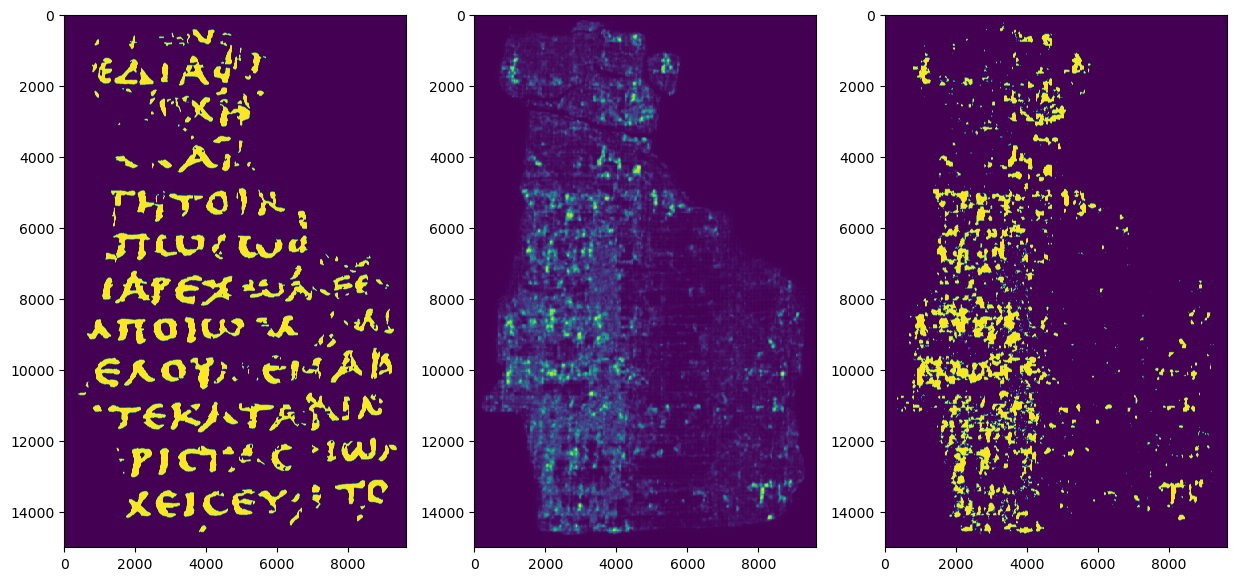

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([9.8312376e+07, 1.8380171e+07, 9.4299570e+06, 6.1113840e+06,
        3.7438170e+06, 2.0777630e+06, 1.5219270e+06, 1.1417710e+06,
        8.5834700e+05, 7.6039300e+05, 5.0558200e+05, 3.8102300e+05,
        3.2320000e+05, 2.5799700e+05, 2.2017000e+05, 1.9672300e+05,
        1.7715400e+05, 1.1207900e+05, 4.0201000e+04, 5.0210000e+03]),
 array([6.65590994e-06, 4.73991817e-02, 9.47917074e-02, 1.42184233e-01,
        1.89576759e-01, 2.36969285e-01, 2.84361811e-01, 3.31754336e-01,
        3.79146862e-01, 4.26539388e-01, 4.73931914e-01, 5.21324439e-01,
        5.68716965e-01, 6.16109491e-01, 6.63502017e-01, 7.10894542e-01,
        7.58287068e-01, 8.05679594e-01, 8.53072120e-01, 9.00464646e-01,
        9.47857171e-01]),
 <BarContainer object of 20 artists>)

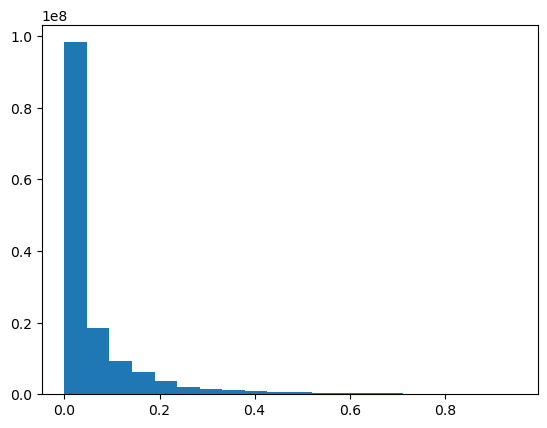

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000